In [11]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, pystan as ps, matplotlib.pyplot as plt
from tqdm import trange
import scipy
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="brain_DL.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6b2d0b798f12e3033751722baf72ffd NOW.


In [ ]:
from numpy import loadtxt

X = np.zeros((68,68,42))
for i in range(42) :
    name = "brain_data/data_column"+str(i+1)
    X[:,:,i] = loadtxt("brain_data/data_column1", comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

In [3]:
N = 21 
m = 10
p = 4
X = npr.binomial(1,0.2,size=[N,m,m]);

In [25]:
np.save("synthetic_data.npy", X)

In [4]:
data = dict(N=N, p=p, m=m, a=0.5, X=X);

In [5]:
control = dict(max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=6, chains=6, iter=1_000, init="random")
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

31.54 minutes to run
Inference for Stan model: anon_model_d6b2d0b798f12e3033751722baf72ffd.
6 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=3000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]        -0.68    0.27    0.5  -1.73  -0.77  -0.64  -0.42   0.13      4   3.24
Z[2,1]        -1.15    0.28    0.5  -1.75  -1.46  -1.33  -1.05  -0.02      3   5.77
Z[3,1]        -1.82    0.44   0.79  -2.65   -2.4  -2.03  -1.75  -0.03      3    7.0
Z[4,1]         -0.2    0.27   0.48  -1.06   -0.7  -0.05   0.17   0.47      3   4.63
Z[5,1]        -1.24    0.36   0.63   -2.2  -1.71  -1.37  -0.92   0.08      3   6.79
Z[6,1]        -0.68    0.34   0.61  -1.72  -1.14  -0.75  -0.04   0.25      3   4.13
Z[7,1]        -0.08    0.17   0.33  -0.66  -0.37   -0.1   0.24   0.52      4   3.14
Z[8,1]        -0.62    0.25   0.44  -1.13   -1.0  -0.76  -0.14    0.2      3   5.93
Z[9,1]        -1.46    0.55   0.98  

In [27]:
n_samples = np.shape(trace['u'])[0]

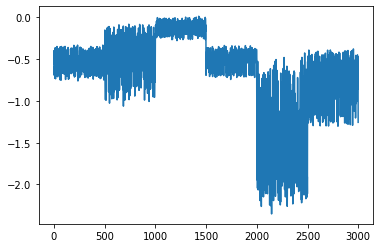

In [6]:
i, j = 1, 3
n = 20

π = trace['Z'][:,i,j] + \
         [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
          for idx in range(n_samples)]
plt.plot(π);

In [7]:
π_chain = np.zeros((n_samples, N,m,m))
for n in range(N) :
    for i in range(m) :
        for j in range(m) :
            π_chain[:,n,i,j] = trace['Z'][:,i,j] + \
                          [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
                           for idx in range(np.shape(trace['u'])[0])]

In [8]:
ll = np.zeros(n_samples)
probs = 1/(1+np.exp(-π_chain))
for itr in range(len(ll)) :
    ll[itr] = np.sum(X*np.log(probs[itr]) + (1-X)*np.log(1-probs[itr]))

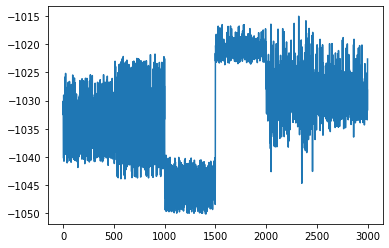

In [9]:
plt.plot(ll)

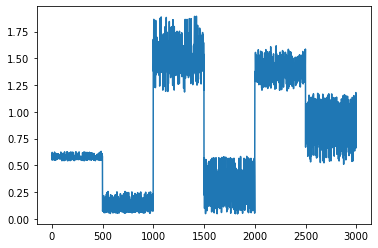

In [12]:
i = 2
plt.plot([scipy.linalg.norm(trace['u'][itr,i,:]) for itr in range(n_samples)])

In [14]:
np.shape(trace['u'])

(3000, 10, 4)

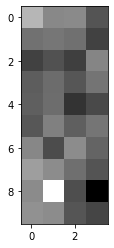

In [20]:
plt.imshow(np.mean(trace['u'],0), cmap="gray")

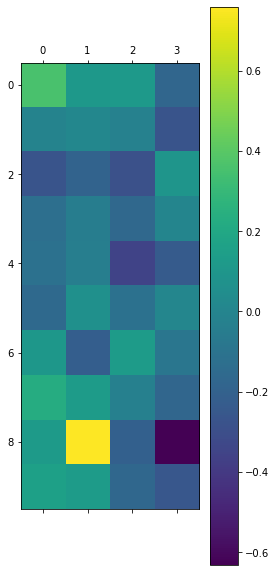

In [22]:
plt.matshow(np.mean(trace['u'],0))
plt.colorbar()

In [26]:
np.shape(trace['u'])

(3000, 10, 4)

In [31]:
np.max(np.linalg.svd(trace['u'][0])[1])

2.3828236660607733

In [33]:
U_normalised = [trace['u'][itr]/np.max(np.linalg.svd(trace['u'][itr])[1]) for itr in range(n_samples)]